# Saturation Height Function (SHF): Automated J-Function Fitting
**Author:** Ade Anggi Naluriawan Santoso | **Project:** Petrophysics & Static Modeling

## 1. Problem Statement
In Reservoir Engineering, distributing water saturation ($S_w$) relative to height above free water level (HAFWL) is critical for Original Oil in Place (OOIP) estimation. While core data provides discrete measurements ($P_c$, $\phi$, $k$), reservoir models require a continuous function.

**Objective:** Automate the fitting of the **Leverett J-Function** to a large dataset of core measurements using Python's `scipy.optimize`.

## 2. Fundamental Physics
The J-Function normalizes capillary pressure curves by accounting for rock quality (permeability and porosity). It allows disparate curves to be grouped into a single universal curve for a specific rock type.

**The J-Function Equation:**
$$J(S_w) = 0.2166 \cdot \frac{P_c}{\sigma \cos \theta} \cdot \sqrt{\frac{k}{\phi}}$$

Where:
* $P_c$: Capillary Pressure (psi)
* $\sigma$: Interfacial Tension (dynes/cm)
* $\theta$: Contact Angle (degrees)
* $k$: Permeability (md)
* $\phi$: Porosity (fraction)

**The Fitting Model:**
We will fit a power-law relationship to the calculated J-indices:
$$S_w = a \cdot (J)^{-b}$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Plotting aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded.")

Libraries loaded.


## 3. Data Loading
We load a synthetic dataset containing 20,000 core measurement points.

In [2]:
# Load dataset
df = pd.read_csv('capillary_pressure_data.csv')

# Display structure
print(f"Dataset Shape: {df.shape}")
display(df.head())
display(df.describe()[['Porosity_frac', 'Permeability_md', 'Pc_psi', 'Sw_frac']])

Dataset Shape: (20000, 7)


,Sample_ID,Porosity_frac,Permeability_md,Pc_psi,Sw_frac,IFT_dynes_cm,Contact_Angle_deg
0,1,0.1808,22.11,26.73,0.3454,30,0
1,2,0.1490,10.32,6.36,1.0000,30,0
2,3,0.1624,26.50,18.33,0.4236,30,0
3,4,0.2347,75.76,0.78,1.0000,30,0
4,5,0.1090,9.20,9.35,0.9283,30,0


,Porosity_frac,Permeability_md,Pc_psi,Sw_frac
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.150220,25.371301,14.991583,0.735391
std,0.052015,48.375140,14.835895,0.274986
min,0.020000,0.110000,0.500000,0.050000
25%,0.114800,5.480000,4.420000,0.486800
50%,0.149900,12.300000,10.485000,0.806600
75%,0.185400,27.610000,20.930000,1.000000
max,0.350000,2630.430000,145.740000,1.000000


## 4. Feature Engineering: Calculating J-Index
Before fitting, we must calculate the J-Index for every row based on the physics equation defined in Section 2.

In [3]:
def calculate_j_function(row):
    """
    Calculates Leverett J-Function Index based on Field Units.
    """
    # Constants
    C = 0.2166 
    
    # Variables
    pc = row['Pc_psi']
    sigma = row['IFT_dynes_cm']
    theta = np.radians(row['Contact_Angle_deg']) # Numpy requires radians
    k = row['Permeability_md']
    phi = row['Porosity_frac']
    
    # Safety check for division by zero
    if phi <= 0 or sigma <= 0:
        return np.nan
        
    term1 = pc / (sigma * np.cos(theta))
    term2 = np.sqrt(k / phi)
    
    return C * term1 * term2

# Apply to DataFrame
df['J_Function'] = df.apply(calculate_j_function, axis=1)

# Clean Data (Remove NaNs or Infinite values created by bad input data)
df_clean = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['J_Function', 'Sw_frac'])

print(f"Rows ready for fitting: {len(df_clean)}")
df_clean[['Permeability_md', 'Porosity_frac', 'Pc_psi', 'J_Function']].head()

Rows ready for fitting: 20000


,Permeability_md,Porosity_frac,Pc_psi,J_Function
0,22.11,0.1808,26.73,2.134181
1,10.32,0.1490,6.36,0.382156
2,26.50,0.1624,18.33,1.690556
3,75.76,0.2347,0.78,0.101180
4,9.20,0.1090,9.35,0.620197


## 5. Curve Fitting (Optimization)
We define a Power Law function $S_w = a \cdot J^{-b}$. 
We use `scipy.optimize.curve_fit` to minimize the least squares error and find the optimal coefficients $a$ and $b$.

In [4]:
# 1. Define the mathematical model
def power_law_model(j_val, a, b):
    return a * np.power(j_val, -b)

# 2. Prepare X and Y vectors
x_data = df_clean['J_Function']
y_data = df_clean['Sw_frac']

# 3. Perform Curve Fitting
# p0 is the initial guess for coefficients [a, b]
params, covariance = curve_fit(power_law_model, x_data, y_data, p0=[1, 1])

a_fit, b_fit = params

print("--- Optimization Results ---")
print(f"Coefficient a: {a_fit:.5f}")
print(f"Exponent b:    {b_fit:.5f}")

--- Optimization Results ---
Coefficient a: 0.64772
Exponent b:    0.19687


## 6. Visualization & QC
We visualize the quality of the fit by overlaying the optimized curve on top of the raw scatter data. In Saturation Height modeling, log-log plots are standard for validating power-law relationships.

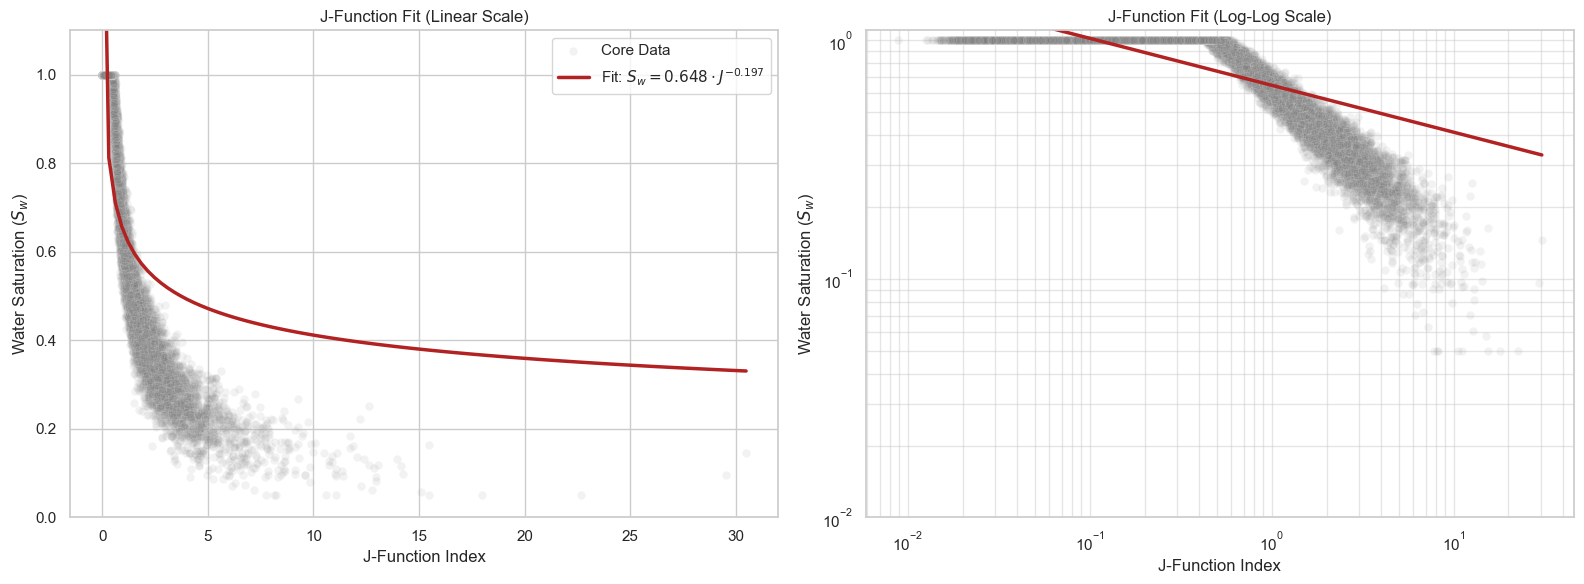

In [5]:
# Generate a smooth line for the fitted equation
j_range = np.linspace(df_clean['J_Function'].min(), df_clean['J_Function'].max(), 100)
sw_fitted = power_law_model(j_range, a_fit, b_fit)
equation_label = f'$S_w = {a_fit:.3f} \cdot J^{{-{b_fit:.3f}}}$'

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Linear Scale
sns.scatterplot(x=df_clean['J_Function'], y=df_clean['Sw_frac'], 
                color='gray', alpha=0.1, ax=ax[0], label='Core Data')
ax[0].plot(j_range, sw_fitted, color='firebrick', linewidth=2.5, label=f'Fit: {equation_label}')
ax[0].set_xlabel('J-Function Index')
ax[0].set_ylabel('Water Saturation ($S_w$)')
ax[0].set_title('J-Function Fit (Linear Scale)')
ax[0].legend()
ax[0].set_ylim(0, 1.1)

# Plot 2: Log-Log Scale
sns.scatterplot(x=df_clean['J_Function'], y=df_clean['Sw_frac'], 
                color='gray', alpha=0.1, ax=ax[1])
ax[1].plot(j_range, sw_fitted, color='firebrick', linewidth=2.5)
ax[1].set_xlabel('J-Function Index')
ax[1].set_ylabel('Water Saturation ($S_w$)')
ax[1].set_title('J-Function Fit (Log-Log Scale)')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_ylim(0.01, 1.1)
ax[1].grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Application: Calculating Sw from Height
With the fitted parameters ($a$ and $b$), we can now predict $S_w$ for any point in the reservoir if we know the rock properties ($\phi, k$) and the Height Above Free Water Level (HAFWL).

**Workflow:** $HAFWL \rightarrow P_c \rightarrow J_{index} \rightarrow S_w$

In [6]:
def predict_sw_at_height(hafwl_ft, k_md, phi_frac, fluid_density_diff_psi_ft=0.083):
    """
    Predicts Sw for a given height and rock quality.
    fluid_density_diff default is approx difference between water (0.433) and oil (0.35)
    """
    # 1. Calculate Pc from Height
    pc = fluid_density_diff_psi_ft * hafwl_ft
    
    # 2. Calculate J-Index (Assuming IFT=30, Theta=0)
    j_idx = 0.2166 * (pc / 30.0) * np.sqrt(k_md / phi_frac)
    
    # 3. Apply Fitted Model
    sw_pred = power_law_model(j_idx, a_fit, b_fit)
    
    return pc, j_idx, sw_pred

# --- Scenario ---
# A high quality rock (500md) vs a low quality rock (10md) at 75 ft above FWL
h = 75

pc_hi, j_hi, sw_hi = predict_sw_at_height(h, k_md=500, phi_frac=0.25)
pc_lo, j_lo, sw_lo = predict_sw_at_height(h, k_md=10, phi_frac=0.12)

print(f"At {h} ft above FWL (Pc = {pc_hi:.2f} psi):")
print(f"1. High Quality Rock (500md): Sw = {sw_hi:.1%}")
print(f"2. Low Quality Rock (10md):   Sw = {sw_lo:.1%}")

At 75 ft above FWL (Pc = 6.23 psi):
1. High Quality Rock (500md): Sw = 56.5%
2. Low Quality Rock (10md):   Sw = 77.2%


---
### 1. Detailed Analysis of the Fit

#### A. The "Entry Pressure" Problem (The Hockey Stick)
Looking at your **Right Plot (Log-Log Scale)**, observe the shape of the grey data points. They form a "Hockey Stick" shape:

* **The Handle (Flat Region):** At low J-values ($J < 0.5$), the data is flat at $S_w \approx 1.0$. Physically, this represents the **Entry Pressure** region. The capillary pressure is not yet high enough to overcome the largest pore throats, so no oil enters the rock, and it remains 100% water-saturated.
* **The Blade (Sloped Region):** At higher J-values ($J > 0.5$), the saturation drops linearly on the log-log scale. This represents the actual displacement of water by oil.

#### B. Why the Model Failed
Your current model is a simple Power Law:
$$S_w = a \cdot J^{-b}$$

On a log-log plot, a simple Power Law appears as a **straight line** with no bends.

* **The Conflict:** The regression algorithm (`curve_fit`) is trying to draw a single straight line through a "Hockey Stick" dataset.
* **The Result:** It compromises. To minimize the error between the "flat" top part and the "steep" bottom part, it draws a line right through the middle. This results in:
    * **Underestimating $S_w$ at low J:** It suggests oil enters immediately, missing the entry pressure physics.
    * **Overestimating $S_w$ at high J:** It predicts ~40% water saturation when the data actually shows ~20%.

---

### 2. How to Improve the Model
You have two main options to fix this: **Data Pre-processing** (easiest) or **Model Complexity** (more robust).

#### Option A: Filter the Data
The simplest fix is to recognize that the Power Law is only valid *after* oil has entered the rock. You should filter out the data where $S_w \approx 1$ before performing the fit.

This forces the model to fit only the "curved" part of the data (the reservoir zone) rather than the underlying aquifer zone.

#### Option B: Add an Irreducible Saturation ($S_{wirr}$) Term
Your current model decays to $S_w=0$ as J goes to infinity. In reality, rock usually hits an irreducible water saturation ($S_{wirr}$) where no more water can be forced out.

**Updated Model:**
$$S_w = S_{wirr} + a \cdot J^{-b}$$

This adds a "floor" to your model, allowing the curve to flatten out at high J-values (the bottom right of your linear plot), which matches the data better.

--- Improved Fit Results ---
a:     0.6274
b:     0.6541
Swirr: 0.0000


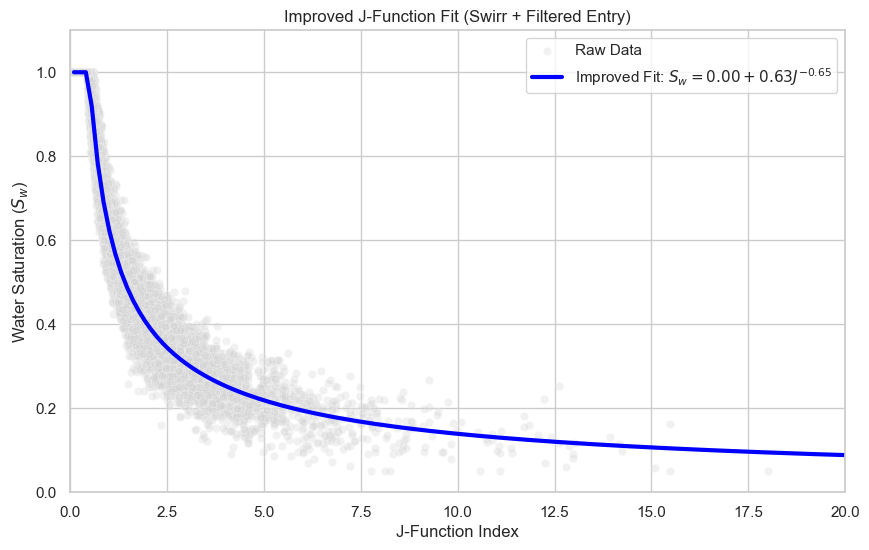

In [7]:
# --- IMPROVED FITTING STRATEGY ---

# 1. Define a more robust model with Irreducible Saturation (Swirr)
def swirr_power_law(j_val, a, b, swirr):
    # This model forces a "floor" at Swirr
    return swirr + a * np.power(j_val, -b)

# 2. Filter Data: Remove the "Entry Pressure" plateau
# We only want to fit the curve where displacement is actually happening.
mask_mobile = df_clean['Sw_frac'] < 0.98
df_mobile = df_clean[mask_mobile]

x_mobile = df_mobile['J_Function']
y_mobile = df_mobile['Sw_frac']

# 3. Fit the Improved Model
# bounds: swirr must be between 0 and 0.5, a and b positive
# p0: Initial guess [a=1, b=1, swirr=0.05]
params_new, cov_new = curve_fit(
    swirr_power_law, 
    x_mobile, 
    y_mobile, 
    p0=[1, 1, 0.05], 
    bounds=([0, 0, 0], [np.inf, np.inf, 1.0])
)

a_new, b_new, swirr_new = params_new

print(f"--- Improved Fit Results ---")
print(f"a:     {a_new:.4f}")
print(f"b:     {b_new:.4f}")
print(f"Swirr: {swirr_new:.4f}")

# 4. Visualization Comparison
j_range = np.linspace(0.1, df_clean['J_Function'].max(), 200)

# Calculate curve using the new parameters
sw_fitted_new = swirr_power_law(j_range, a_new, b_new, swirr_new)
# Cap the result at 1.0 (physics constraint)
sw_fitted_new = np.clip(sw_fitted_new, 0, 1.0)

plt.figure(figsize=(10, 6))
# Plot filtered data for clarity
sns.scatterplot(x=df_clean['J_Function'], y=df_clean['Sw_frac'], 
                color='lightgray', alpha=0.3, label='Raw Data')
                
plt.plot(j_range, sw_fitted_new, color='blue', linewidth=3, 
         label=f'Improved Fit: $S_w = {swirr_new:.2f} + {a_new:.2f}J^{{-{b_new:.2f}}}$')

plt.xlabel('J-Function Index')
plt.ylabel('Water Saturation ($S_w$)')
plt.title('Improved J-Function Fit (Swirr + Filtered Entry)')
plt.legend()
plt.ylim(0, 1.1)
plt.xlim(0, 20)
plt.show()